# 04.Regression

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.mplot3d import proj3d # may be needed for our regression trees
import collections
import os

The goal of this chapter is to take a tour of some most used regression algorithms, show how they work and how their parameters are tuned, and explore situations when you might want to use these methods. 

We will journey through:
* linear regression (with gradient descent) 
* general & generalized linear models
* polynomial regressoin (with bayesian approach)
* regression trees
* isotonic regression
* piecewise regression
* logit & softmax

## Preamble

Regressions have played an important role in business analytics and scientific research for decades, and now play a key role role in many of our ML predictive models. 

In its simplist form, a regression takes input and maps it to output using a link function. A simple linear predictor function could be something like: $y = 2 * x$ where $x$ is a random integer from set $X$.  

If I gave you an $x$ (say 2), and asked you to generate the corresponding $y$, you could just plug it into function to get the answer (4). In this way, our function has created a linear map between the input 2 and the output 4.  

But what if we don't know what the predictor function is? How might we discover it by working backwards from the data?

This is where regression algorithms come in. We are presented with inputs and outputs from the world, and we deduce the best function that explains what we wee. 

## Linear regression

You may have heard linear regression as the process of finding the "line of best fit" in 2D data (the line that optimally minimizes the sum of squared differences between every datapoint and the line). This is a good jumping off point. 

If we remember the equation for a line is $y = mx + b$, we are looking for the values of m (the slope) and b (intercept) that would best generalize the relationship between x and y. 

Sometimes we'll have more than one independent variables, and so let's extend the equation for a line to a more generalized linear function that accomodate more inputs:

> $\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} ...+ \theta_{n}x_{n} + \epsilon_{i}$

> or

> $\hat{y} = \mathbf{\theta^T}\cdot\mathbf{x} + \epsilon$

In the first equation, there is an initial bias term $\theta_{0}$, which serves as the intercept of our function, and then a series of weighted coefficients multipled by each of our indpendent (explanatory) variables. The goals it to try to set the weights for so that modulate the input variables in such a way that sums will yield the best approximation of the target output $\hat{y}$. It's like adjusting the levels on mixing board when making a pop song - e.g. the weights determine how much "cow bell" there should be. 

The second equation says the same thing, only all the $\theta$'s have been rounded up togther into matrix $\mathbf{\theta}$, and all the explanatory variables have been rounded up into a matrix $\mathbf{x}$. The dot product between the two yields the prediction. For a review of dot product and other linear algegra notation, check out: https://github.com/ageron/handson-ml/blob/master/math_linear_algebra.ipynb

The $\epsilon$ term is a "disturbance term", which is added to account for the noise that exists. 

In [59]:
rand = np.random.RandomState(42)
mean = [0, 0]
cov = [[1, 2], [2,8]]
X = rand.multivariate_normal(mean, cov, 100)

x = np.linspace(-2, 2, 100)
y = x *2

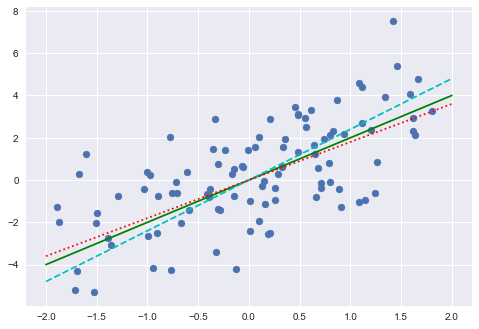

In [65]:
plt.scatter(X[:,0], X[:,1])
plt.plot(x, x*2,'-g')
plt.plot(x, x*2.4, '--c')
plt.plot(x, x*1.8, ':r')

I've plotted some random points, and began trying out different lines that might explain the relationship, but how do I know what line is best?

To find the ideal parameters (the $m$ and $b$ in our line equation, or the $\theta$ matrix in our generalized quations), we'll need a cost function that will help us gauage how close we're getting to the actual labels. For linear regression we typically use **Mean Square Error (MSE)**:

$MSE(\theta) = \frac{1}{m}\sum_{i=1}^m(\theta^T\cdot\mathbf{x}^i - y^i)^2$

The part after the $\sum$ should look familiar - it's the difference between our predicted $\hat{y}$ value ($\theta^T\cdot\mathbf{x}^i$) and the actual $y$ value for each $i$ instance. Square the differences, sum them up across all $m$ instances, and divide by the number $m$ (like you would when calculating any mean), and you've got your MSE. 

The MSE tells us how off we are (on average), but we still need a way to determine what the optimal weights should be. 

The umbrella category all this falls under is called **ordinary least squares (OLS)** and I'd like to take a look at what is often called the **normal equation**, which is used to . For now, we'll stick with a general overview of how this works, but please check out the following article if you're looking for a walk through of the derivation: http://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression

We'll jump into the derivation story right before the end:

$\mathbf{X}^T\cdot\mathbf{X}\cdot\theta = \mathbf{X}^T\cdot\mathbf{y}$

This equation makes intuitive sense if we remember that we're ultimately seeking to estimate the ideal parameters to equal what would be observed with the true labels. By take the dot product of the transposed matrix of inputs ($\mathbf{X}^T$) and the vector of labels ($\mathbf{y}$), we arrive at the output we are trying to estimate with our dot product of the X transposed matrix and the parameter theta. All we have do know is solve for $\theta$ by multiplying both sides by ($\mathbf{X}^T\cdot\mathbf{X})^-1$

$\hat{\theta} = (\mathbf{X}^T\cdot\mathbf{X})^-1\cdot\mathbf{X}^T\cdot\mathbf{y}$


NOTE: The $T$ indicates the matrix transpose (flips the columns and rows), which is needed to orient the data in the way needed to calculate the dot product. Transpose matrices always makes my eyes cross, but it keeps our brains ... flexible?

I love the example below, because it shows how different combinations of slopes and intercepts (the m's and b's) will yield different errors (the x and y axes of the graph), and that ultimately, we're looking to find the lowest point in the valley (z axis value) to tell us what our optimal parameter values should be. 

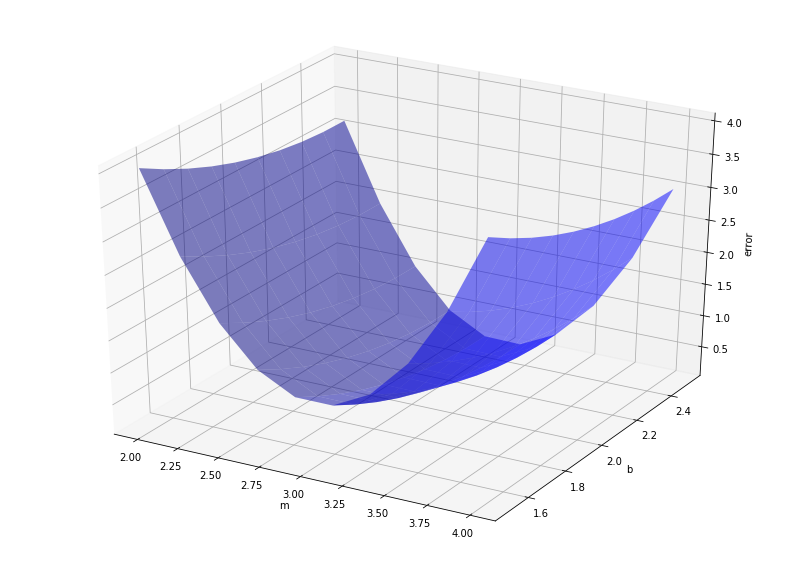

In [17]:
#https://stackoverflow.com/questions/28542686/3d-plot-of-the-error-function-in-a-linear-regression

def error(m, b, points):
    totalError = 0
    for i in range(0, len(points)):
        totalError += (points[i].y - (m * points[i].x + b)) ** 2
    return totalError / float(len(points))

x = y = np.arange(-3.0, 3.0, 0.05)
Point = collections.namedtuple('Point', ['x', 'y'])

m, b = 3, 2
noise = np.random.random(x.size)
points = [Point(xp, m*xp+b+err) for xp,err in zip(x, noise)]

fig = plt.figure(figsize = (14, 10))
ax = fig.add_subplot(111, projection='3d')

ms = np.linspace(2.0, 4.0, 10)
bs = np.linspace(1.5, 2.5, 10)

M, B = np.meshgrid(ms, bs)
zs = np.array([error(mp, bp, points) 
               for mp, bp in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.5)

ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('error')

plt.show()

Using the normal equation to calculate $\theta$ can be useful with small feature sets, but we'll now look at an algorithm commonly used to generate weights in our machine learning projects. 

**Gradient descent** is an optimization algorithm that minimizes the cost function by making iterative adjustments to parameters. There are three common flavors:
* BATCH - partial parameter derivatives are calculated across ALL instances and grouped into a gradient vector, which indicates where to take the next step
* STOCHASTIC - the gradient vector is calculated using the partial derivative of ONE random instance in the dataset
* MINI-BATCH - like stochastic, only with batches of random instances instead of just one

We first must calculate the **gradient** of the cost function for each parameter $\theta$. 

From Wikipedia:

>Like the derivative, the gradient represents the slope of the tangent of the graph of the function. More precisely, the gradient points in the direction of the greatest rate of increase of the function, and its magnitude is the slope of the graph in that direction.

Essentially, the gradient tells you which direction is up, so you can use it to decide which direction to step in order to descend (directly opposite of the direction the gradient is pointing). 

Here's how the gradient is constructed for batch graident descent (in matrix notation): 

$\nabla_{\theta}MSE(\theta) = \frac{1}{m}\mathbf{X}^T\cdot(\mathbf{X}\cdot\theta-\mathbf{y})$

Since the gradient points in the direction of the greatest increase, our function will step in the opposite direction until it finds the global minima of the convex equation. The convext part is worth underscoring. If this wasn't a convex equation, we wouldn't be sure if our gradient stepping was leading us to a local minima or a global minima, so thank goodness MSE cost functions for linear models are convex!

$\theta^{(next step)} = \theta - n\nabla_{\theta}MSE(\theta)$

The $n$ (learning rate) determines the size of the downhill step, and in general we don't want to step to large (might keep stepping over the minima) or too small (might take forever to converge). Converengence is the name of the game. As we progress, we should eventually see the steps getting smaller and smaller, which will be a sign we're honing on the minima. We want to get to the lowest point of the convex function as fast as possible. 

Setting an appropriate learning rates is a topic unto itself, but one trick is you use grid search to find an optimal learning rate. Also, if you're interested in this topic, check out this story on momentum (one of the methods we use to ensure we don't get stuck in local minima): https://distill.pub/2017/momentum/

We also have to decide how many times you want to iterate over this stepping process, and to help with this you can set a tolerance level, $\epsilon$, that will stop the iteration once the values you're getting back fall below that level. 

#### Regularizations (ridge, lasso, elastic net)

There are three regularized versions of linear regression that I want to mention in passing, as they will come in handy when trying to reduce overfitting of your data. Basically, if you normalize the data in some way before optimizing your cost function, you can increase your liklihood of building a model that is more useful in novel situations. There are three tools often used to bound the weights so they can only get so large or small. 

* **Ridge Regression** adds a regulization term to $MSE(\theta)$ in the cost function: $\alpha\frac{1}{2}\sum^n_{i=1}\theta^2_{i}$

* **Lasso Regression** adds a different regularization term $MSE(\theta)$ in the cost function: $\alpha\sum^n_{i=1}\lvert\theta_{i}\rvert$

* **Elastic Net** applies whatever is the min of Ridge or Lasso

## Polynomial regression

Sometimes the linear mapping function that makes the most sense involves a higher degree polynomials, and that's where polynomial regression comes in. 

While it can be prone to overfitting, I'm fond of polynomial regression in situations where the data is markedly curvilinear. 

The equation for the line of best fit will look a lot like our linear regression (with an intercept and coefficients for each inputer parmater), yet for polynomial regression there will be at least one variable with a power greater than 1. 

In all multiple linear regressions, we need to account for overfitting, which gets into a broader conversation of bias and variance I'm saving until the chapter on optimization. For now, let's splash around in the regression concepts some more.  

#### Bayesian approach

Polynomial regressions are useful at capturing more details of the variance, and really come alive when they take on a Bayesian flavor (assessing the percentage of variance captured as we move through the function). 

## Regression trees

Regression Trees (or, more specifically, the Classification and Regression Tree (CART) algorithm) work the same way as their classficition counterparts (Decision Trees), only when you get down to the terminal node (leaf) in your search, your delivered a value instead of a classification. The general premise is that you are presented with input data, and make your way through a binary search algorithm until you can't take any more steps.  

To train, or "grow", a regression tree, you must choose an algorithm to determine the optimal architecture. This is typically accomplished by using one of two impurity measures (which in general yield similiar trees):  

* **Gini**
A node's Gini score measures class "purity", which is to say homogeneity of classification of the training set. If all the instances are from the same class, the node is "pure". It's measured by suming the squared rations of class instances in the training set and subtracting that sum from 1. 

> $G_{i} = 1 - \sum^n_{k = 1}p_{i,k}^2$

* **Entropy**
A node's entropy is zero when all its members are of the same class.

> $H_{i} = - \sum^n_{k = 1}p_{i,k}log(p_{i,k})$

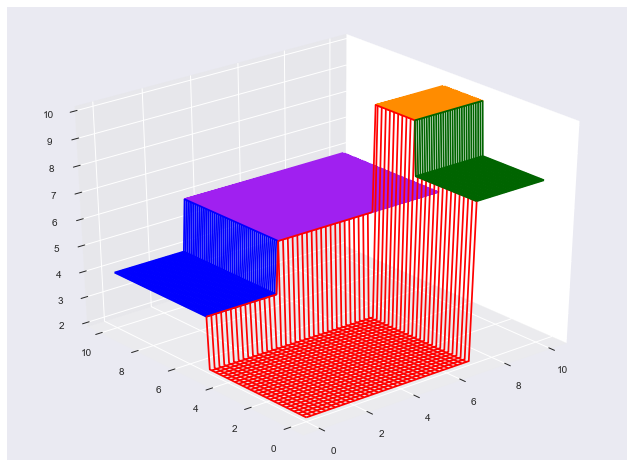

In [69]:
# Here's a super cute graphic for regression trees from Kevin Murphy's book

t1 = 5
t3 = 3
t2 = 7
t4 = 3

r = np.linspace(2, 10, 5)

#A function to return a tree for given (x1,x2) coordinates
def ManualTree(x1, x2):
    if x1 <= t1:
        if x2 <= t2:
            z = r[0]
        else:
            if x1 <= t3:
                z = r[3]
            else:
                z = r[4]
    else:
        if x2 <= t4:
            z = r[1]
        else:
            z = r[2]
    return(z)

ManualTree = np.vectorize(ManualTree)

x = np.linspace(0,10,100)
X, Y = np.meshgrid(x, x)
Z = ManualTree(X.T,Y.T)

#A 3D matrix for determining which colors go where.

def DivList(list1, den):
    return([e/den for e in list1])

#This tells us which color we use for which output tree value. Intended to match with the latex tree graphic.
def ColorMapper(z):
    if z == r[0]:
        out = DivList([255.0, 0.0, 0.0], 255.0)
    elif z == r[1]:
        out = DivList([0.0, 0.0, 255.0], 255.0)
    elif z == r[2]:
        out = DivList([160.0, 32.0, 240.0], 255.0)
    elif z == r[3]:
        out = DivList([0.0, 100.0, 0.0], 255.0)
    else:
        out = DivList([255.0, 140.0, 0.0], 255.0)
    return(out)

#Manually build the tree, one output tree value at a top. 
#For some spots, we need to add in the walls to show difference between two tree values.
fig = plt.figure(figsize=(20.0/1.8, 15.0/1.8))
ax = fig.add_subplot(111, projection='3d')
for val in r:   
    if val in [2, 4, 8]:
        logi = Z == val
        if val == 2:
            logi[50,0:70] = True
            logi[:51,70] = True
            shp = (51, 71)
        elif val == 4:
            logi[50:,30] = True
            shp = (50, 31)
        else:
            logi[30,70:] = True
            shp = (31, 30)
        x = X[logi].reshape(shp)
        y = Y[logi].reshape(shp)
        z = Z[logi].reshape(shp)
    else:
        x = X[Z==val]
        y = Y[Z==val]
        z = val
    ax.plot_wireframe(x, y, z, color=ColorMapper(val))
        
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(elev=30, azim=230)
plt.show()

## Isotonic Regression

I include isotonic regression (also knows as monotonic regression) in our discussion, because I think it represents an interesting alteranative to the other methods we've seen. Essentially this algorithm draws a line of best fit for data that has to satisfy two conditions: be non-decreasing at all points and lie as close to the points as possible. Imagine drawing a line of best fit on a plot of points where you must keep your pen on the paper at all times, and always be moving up and to the right. That's what an isotonic regression is doing, and it comes in handy when your data is distributed in what looks to be linear globally, bus it actually more tiered when you zoom in on the segments. 


## Piecewise Regression

I'm a fan of this regression because of one of it's nicknames, "broken stick", but also because I find a lot of applications in time-based events in the real world. They crop up everywhere. Something behaves one way for a period of time, then shifts for a period, then shifts back. Like traffic in response to accidents or user behavior in dynamic pricing markets. 

## Logit & Softmax

Logistic regression (logit) relies on a sigmoid function to make a binary classification. It it's classic form, it returns a simple "yes" or "no", but it also has other flavors, such as mulitnomial logistic regression (multiple class outputs) or multiple logistic regression (multiple parameter inputs). 

It's worth noting that in the case of the multinomial logistic regression, a softmax function is used to determine the class. We'll see this again in reinforcement learning, so let's spend a little time with this function.

SOFTMAX FUNCTION:

$\hat{p_{k}} = \sigma(s(\mathbf{x}))_{k} = \frac{\mathrm{e}^{s_{k}(\mathbf{x})}}{\sum^K_{j=1}\mathrm{e}^{s_{j}(\mathbf{x})}}$

To explain this function down, I'm going to quote Aurélian Géron's book directly, because I think his explanation sums it up:

* $K$ is the number of classes.
* $s(\mathbf{x})$ is a vector containing the scores of each class for the instance $\mathbf{x}$.
* $\sigma(s(\mathbf{x}))_{k}$ is the estimated probability that the instance $\mathbf{x}$ belongs so class $k$ given the scores of each class for that instnace.

NOTE: While the convention is typically to set exponents in equations as $\mathrm{exp}^{value}$, I like to use $\mathrm{e}$ to drive home the point that when we put variables as exponents, we are typically using the variable to define the shape of resulting space. For me at least using the $\mathrm{e}$ helps reiterate that, by invoking all the other geometric contexts we have encountered this context.

Our adoption of a logit or softmax function represents a desire to highlight the probability of each classification by boosting the contrast through the sigmoid function. The important concepts here are the relationship between the max-likelihood (which sets our target probability), cross entropy (which give us a numeric value that relates to how likely our model is accurately labeling - with low values being good, and high values being bad), and our error function, which ultimately seeks to minimize the cross-entropy and deliver us the best parameters. 

## Summary

At the end of the day, we define an error function to see how well our trained model predicts novel data, and select the paramters that minimize the error function. 

## Resources

* [Gradient Desescent derivation blog post](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop)
* [mplot3d](https://matplotlib.org/mpl_toolkits/mplot3d/api.html)
* [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook)
* [Machine Learning: A Probabilitistic Perpsective](https://github.com/probml/pyprobml)
* [Hands-On Machine Learning with Scikit-Learn & TensorFlow](https://github.com/ageron/handson-ml)